## Imports, Classes, and Constants

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn.utils import shuffle
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])
    
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

## Data Preprocessing

In [132]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1787
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,441
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [133]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X, y = shuffle(X, y, random_state=RANDOM_SEED)

X[0:10], y[0:10]

(array(['I know. I know. I get it. I’m gonna handle it, okay Just let me handle it.',
        'And what word would you use, Mr. Secretary?', 'Working on it.',
        'Edwards Tower, this is Lieutenant Colonel James Rhodes, inbound from three miles east at 5,000 feet…',
        'You like going in the garage?  So does Daddy.  It’s all right.  Mommy never wears what I buy her. I just want to thank you folks for dropping by.  It’s not every day one gets to contemplate biting it on an inter-dimensional timescape.',
        'Don’t tell them. Fax them…', 'Is that...?', 'Hello?', 'Jane?',
        'Well, like the old man said. Together.'], dtype='<U1388'),
 array(['PEPPER POTTS', 'NATASHA ROMANOFF', 'STEVE ROGERS', 'JAMES RHODES',
        'TONY STARK', 'PEPPER POTTS', 'JAMES RHODES', 'PETER PARKER',
        'THOR', 'TONY STARK'], dtype='<U16'))

## Models

In [134]:
cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
hyperparameter_cross_validator = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [135]:
stem_count_vectorizer = StemCountVectorizer(binary=False)
tfidf_transformer = TfidfTransformer()
nb_classifier = MultinomialNB(alpha=0.01)

In [138]:
count_params = {'vect__stop_words': [None, stopwords.words('english')],
              'vect__ngram_range': [(1,1), (1,2)]}

tfidf_params = {'tfidf__use_idf': [True, False]}

nb_params = {'clf__fit_prior': [True, False]}

In [139]:
pipe13 = Pipeline([('vect', stem_count_vectorizer),
                  ('tfidf', tfidf_transformer),
                  ('clf', nb_classifier)])

parameters13 = {**count_params, **tfidf_params, **nb_params}

model13 = GridSearchCV(pipe13, parameters13, cv=hyperparameter_cross_validator, scoring=score_method, n_jobs=-1, verbose=6)

## Nested CV Balanced Accuracy

In [140]:
models = {"model 13": model13}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 31.5min remaining: 47.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.6min remaining: 21.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.1min finished


,model 13
fold,
0,0.274557
1,0.285970
2,0.269714
3,0.272935
4,0.288112
mean,0.278257
std,0.007370
max,0.288112


## Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 31.7min remaining: 47.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 31.8min remaining: 21.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.2min finished


Balanced Accuracy: 0.2782638052929735
Balanced Accuracy: 0.27826380529297345


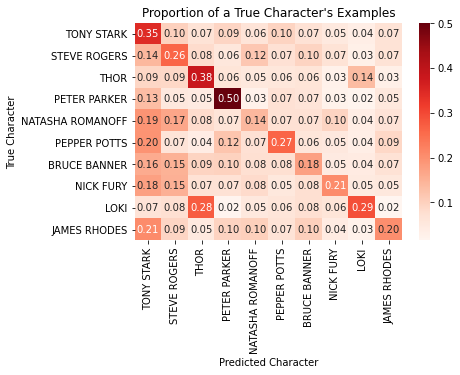

In [141]:
yhat = cross_val_predict(model13, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Recalls

In [142]:
recalls = pd.DataFrame(np.diagonal(normalized_conf_matrix.to_numpy()), index=main_characters, columns=["recall"])
recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls.to_csv("./front_end/production_recalls.csv")

recalls

,recall
PETER PARKER,0.500907
THOR,0.383546
TONY STARK,0.345831
LOKI,0.293578
PEPPER POTTS,0.265306
STEVE ROGERS,0.264074
NICK FURY,0.207650
JAMES RHODES,0.204403
BRUCE BANNER,0.176781
NATASHA ROMANOFF,0.140562


## Predictions

In [143]:
prediction_table = pd.DataFrame({"line": X, "true character": y, "predicted character": yhat})
print(X.shape)

#mcu_subset_character_line_movie = pd.DataFrame({"character": mcu_subset["character"], "line": mcu_subset["line"], "movie": mcu_subset["movie"]})

#prediction_table.line = prediction_table.line.astype(str)
#mcu_subset_character_line_movie.line = mcu_subset_character_line_movie.line.astype(str)

#prediction_table = prediction_table.merge(mcu_subset_character_line_movie, left_on=["line", "true character"], right_on=['line', 'character'], how="left")

dump(prediction_table, "./front_end/production_predictions.joblib")

prediction_table.head()

(6507,)


,line,true character,predicted character
0,"I know. I know. I get it. I’m gonna handle it,...",PEPPER POTTS,JAMES RHODES
1,"And what word would you use, Mr. Secretary?",NATASHA ROMANOFF,NICK FURY
2,Working on it.,STEVE ROGERS,JAMES RHODES
3,"Edwards Tower, this is Lieutenant Colonel Jame...",JAMES RHODES,TONY STARK
4,You like going in the garage? So does Daddy. ...,TONY STARK,TONY STARK


## Learning Curve

In [144]:
def plot_learning_curve(estimator, title, X, y, axes=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, verbose=6)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    return

[learning_curve] Training set sizes: [ 520 1691 2862 4033 5205]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed:  8.6min remaining: 206.0min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed: 32.5min remaining: 102.9min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed: 53.7min remaining: 68.3min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed: 65.1min remaining: 36.6min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 72.7min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 85.2min finished


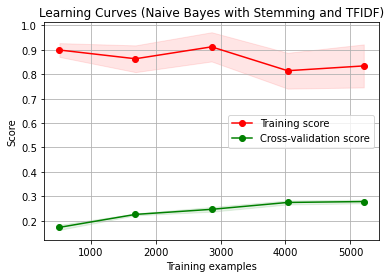

In [145]:
title = "Learning Curves (Naive Bayes with Stemming and TFIDF)"

plot_learning_curve(model13, title, X, y, cv=cross_validator)

## Peformance as a function of words

Do examples with more words (longer examples) get classified correctly more often?

In [146]:
prediction_table['words'] = prediction_table['line'].str.split(" ").str.len()
prediction_table['correct_prediction'] = (prediction_table['true character'] == prediction_table['predicted character']).astype('int64')

In [147]:
reg_model = smf.ols('prediction_table["correct_prediction"] ~ prediction_table["words"]', data=prediction_table).fit()

reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     prediction_table["correct_prediction"]   R-squared:                       0.021
Model:                                                OLS   Adj. R-squared:                  0.021
Method:                                     Least Squares   F-statistic:                     139.3
Date:                                    Wed, 06 Jan 2021   Prob (F-statistic):           7.80e-32
Time:                                            23:39:00   Log-Likelihood:                -4107.1
No. Observations:                                    6507   AIC:                             8218.
Df Residuals:                                        6505   BIC:                             8232.
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2495      0.007     34.410      0.000       0.235       0.264
prediction_table["words"]     0.0050      0.000     11.805      0.000       0.004       0.006
==============================================================================
Omnibus:                     5837.202   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1159.116
Skew:                           0.844   Prob(JB):                    2.00e-252
Kurtosis:                       1.807   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'accuracy')

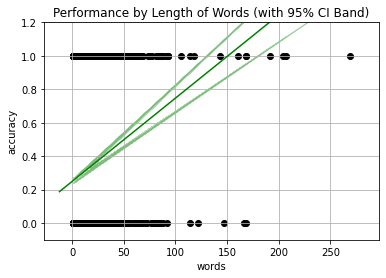

In [148]:
def abline(intercept, slope, col):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color=col)
    

plt.scatter(x = prediction_table['words'].to_numpy(),
            y = prediction_table['correct_prediction'].to_numpy(),
            color='black')

abline(reg_model.params[0], reg_model.params[1], 'green')

conf_pred_intervals = reg_model.get_prediction(prediction_table['words']).summary_frame()

plt.fill_between(prediction_table['words'].to_numpy(), conf_pred_intervals['mean_ci_lower'], conf_pred_intervals['mean_ci_upper'], alpha=0.3, color='green')

plt.grid()
plt.ylim(-0.1,1.2)
plt.title('Performance by Length of Words (with 95% CI Band)')
plt.xlabel('words')
plt.ylabel('accuracy')

Using a t test and a confidence level of 95% ($\alpha=0.05$), we **reject** the null hypothesis that there is no relationship between the number of words in an example and our model's performance on it ($t=11.805$, $p<0.001$).

## Export Model

In [149]:
model13.fit(X,y)
model13.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  71 out of  80 | elapsed:  6.4min remaining:   48.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.8min finished


{'clf__fit_prior': False,
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [150]:
prod_model = Pipeline([('vect', StemCountVectorizer(binary=False, ngram_range=(1,2), stop_words=None)),
                  ('tfidf', TfidfTransformer(use_idf=False)),
                  ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

In [151]:
prod_model.fit(X,y)
dump(prod_model, './front_end/production_model.joblib')

['./front_end/production_model.joblib']